# kaggle study 21일차(Fruit360)

코드출처 : https://www.kaggle.com/amadeus1996/fruits-360-transfer-learning-using-keras

# Fruits-360 - Transfer Learning using Keras and ResNet-50¶
이 노트북은 Fruits-360 데이터 세트에 대한 전송 학습을 간략하게 적용한 것입니다.
이 데이터 세트는 64개 과일의 42345개의 이미지로 구성됩니다.
우리는 Transfer 학습 접근 방식을 일반 접근 방식과 비교합니다.
정확도는 2 epoch 내에서 98.44%입니다.  
내용:
1. 전이 학습에 대한 간략한 설명
2. Kaggle 커널을 사용하여 전이 학습을 시행
3. 데이터를 읽고 시각화
4. 모델을 만들고 컴파일
5. 사전 훈련된 모델을 교육하고 검증
6. 바닐라 모델을 교육하고 검증
7. 사전 훈련된 모델과 바닐라 모델의 비교

In [1]:
import os
from os import listdir, makedirs
from os.path import join, exists, expanduser

from keras import applications
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers
from keras.models import Sequential, Model
from keras.layers import Dense, GlobalAveragePooling2D
from keras.layers import Activation, Dropout, Flatten, Dense
from keras import backend as K
import tensorflow as tf

## Transfer Learning
전송 학습에서 우리는 먼저 기본 데이터 세트와 작업을 기반으로 기본 네트워크를 훈련한 다음 학습된 기능의 용도를 변경하거나 두 번째 대상 네트워크로 전송하여 대상 데이터 세트와 작업에 대해 훈련합니다. 이 프로세스는 기능이 기본 태스크에 한정되지 않고 기본 태스크와 대상 태스크 모두에 적합한 일반인 경우 작동하는 경향이 있습니다.

Lisa Torrey와 Jude Shavlik은 이전 학습 챕터에서 이전 학습을 사용할 때 다음과 같은 세 가지 가능한 이점을 설명합니다.

더 높은 시작입니다. 소스 모델의 초기 기술(모델을 다듬기 전)이 그렇지 않은 경우보다 높습니다.
높은 경사도입니다. 소스 모델을 교육하는 동안 스킬의 향상 속도는 그렇지 않은 경우보다 더 가파릅니다.
더 높은 점근입니다. 훈련된 모델의 융합된 기술은 그렇지 않은 경우보다 더 우수합니다.

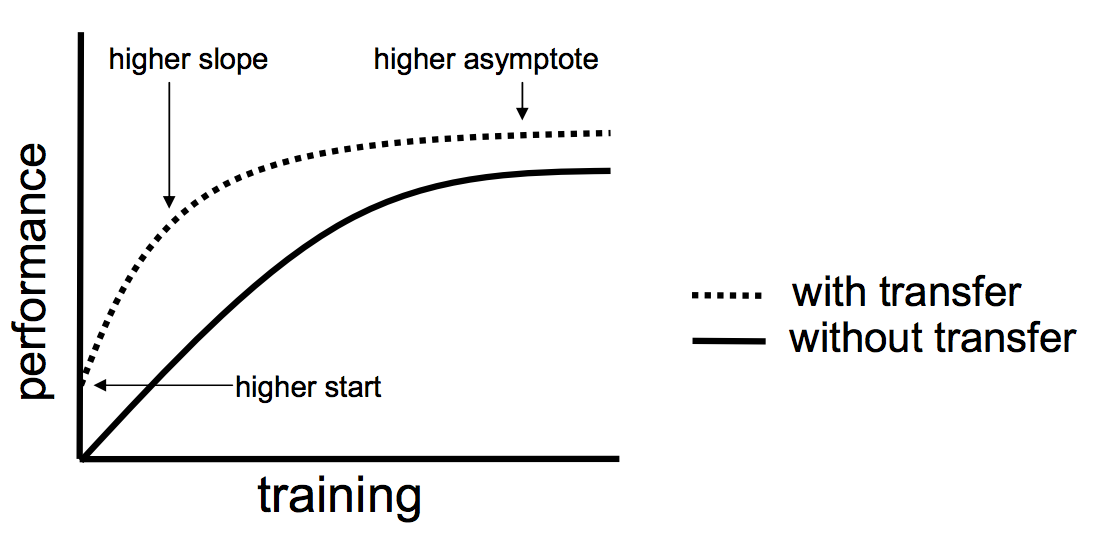

기본적으로 사전 훈련된 모델(다른 사람에 의해 대규모 데이터 세트에서 훈련된 네트워크의 가중치와 매개 변수)을 취하고 자체 데이터 세트로 모델을 "세밀하게 조정"합니다. 이 사전 훈련된 모델은 초기화된 가중치를 제공하여 더 빠른 수렴을 유도하거나 관심 작업의 고정 형상 추출기로서의 역할을 할 것이라는 생각입니다.

이러한 두 가지 주요 전이 학습 시나리오는 다음과 같습니다.

- 컨벤트를 미세 조정: 랜덤 초기화 대신 imagenet 1000과 같은 대규모 데이터 세트에서 학습된 네트워크와 같은 사전 훈련된 네트워크로 네트워크를 초기화합니다. 나머지 훈련은 평소와 같이 보입니다. 이 시나리오에서는 전체 네트워크를 관심 있는 데이터 세트에 대해 재교육해야 합니다.

- ConvNet을 고정 기능 추출기로 사용 : 여기서는 최종 완전히 연결된 계층을 제외한 모든 네트워크의 가중치를 동결합니다. 마지막으로 완전히 연결된 이 레이어는 무작위 가중치를 가진 새로운 레이어로 대체되고 이 레이어만 훈련됩니다.
  
이 노트북에서는 첫 번째 시나리오를 시연합니다.  
  
## Transfer Learning using Kaggle Kernels
Keras Pretrained Models 데이터 세트를 사용합니다.
Kaggle Kernels는 네트워크 연결을 사용하여 사전 훈련된 Keras 모델을 다운로드할 수 없습니다. 이 데이터 세트는 Kaggle 커널 환경에서 가장 선호하는 사전 훈련된 모델을 사용하는 데 도움이 됩니다.

우리가 해야 할 일은 미리 훈련된 모델을 케라가 찾고 있는 캐시 디렉토리(~/.keras/models)에 복사하는 것입니다.

In [2]:
cache_dir = expanduser(join('~', '.keras'))
if not exists(cache_dir):
    makedirs(cache_dir)
models_dir = join(cache_dir, 'models')
if not exists(models_dir):
    makedirs(models_dir)
    
!cp ../input/keras-pretrained-models/*notop* ~/.keras/models/
!cp ../input/keras-pretrained-models/imagenet_class_index.json ~/.keras/models/
!cp ../input/keras-pretrained-models/resnet50* ~/.keras/models/

print("Available Pretrained Models:\n")
!ls ~/.keras/models

'cp'은(는) 내부 또는 외부 명령, 실행할 수 있는 프로그램, 또는
배치 파일이 아닙니다.
'cp'은(는) 내부 또는 외부 명령, 실행할 수 있는 프로그램, 또는
배치 파일이 아닙니다.


Available Pretrained Models:



'cp'은(는) 내부 또는 외부 명령, 실행할 수 있는 프로그램, 또는
배치 파일이 아닙니다.
'ls'은(는) 내부 또는 외부 명령, 실행할 수 있는 프로그램, 또는
배치 파일이 아닙니다.


## Reading and Visualizing the Data
#### Reading the Data
다른 케라스처럼, 이미지 증강 API는 간단하고 강력합니다. 우리는 Image Data Generator를 사용하여 데이터를 가져와 네트워크에 제공할 것입니다.

Keras는 이미지 데이터 준비 및 증강을 위한 구성을 정의하는 Image Data Generator 클래스를 제공합니다. 전체 이미지 데이터 세트에 대한 작업을 메모리에 수행하는 대신, API는 딥 러닝 모델 피팅 프로세스를 통해 반복되도록 설계되어 있어 적시에 증강 이미지 데이터를 생성할 수 있습니다. 이렇게 하면 메모리 오버헤드가 감소하지만 모델 교육 동안 약간의 시간 비용이 추가됩니다.

데이터 생성기 자체는 실제로 반복자로, 요청 시 디렉토리에서 이미지 샘플 배치를 반환합니다. flow_from_directory() 함수를 호출하여 배치 크기를 구성하고 데이터 생성기를 준비하고 이미지 배치를 가져올 수 있습니다.

In [3]:
#이미지의 차원
# 우리는 미리 훈련된 모델에 따라 img_width와 img_height를 설정
img_width, img_height = 224, 224
# 사용할 것입니다. ResNet-50의 입력 크기는 224 x 224 x 3입니다.

train_data_dir = 'C:/Users/이동훈/Desktop/github/kaggle/kagglestudy/Data/fruits/Training/'
validation_data_dir = 'C:/Users/이동훈/Desktop/github/kaggle/kagglestudy/Data/fruits/Test/'
nb_train_samples = 31688
nb_validation_samples = 10657
batch_size = 16

In [4]:
train_datagen = ImageDataGenerator(rescale=1. / 255,shear_range=0.2,zoom_range=0.2,horizontal_flip=True)

test_datagen = ImageDataGenerator(rescale=1. / 255)

train_generator = train_datagen.flow_from_directory(train_data_dir,
                                                    target_size=(img_height, img_width),
                                                    batch_size=batch_size,class_mode='categorical')

validation_generator = test_datagen.flow_from_directory(validation_data_dir,
                                                        target_size=(img_height, img_width),
                                                        batch_size=batch_size,
                                                        class_mode='categorical')

Found 67692 images belonging to 131 classes.
Found 22688 images belonging to 131 classes.


## Visualizing the Data

In [5]:
import pandas as pd
from plotly.offline import init_notebook_mode, iplot
import plotly.graph_objs as go
init_notebook_mode(connected=True)

In [6]:
training_data = pd.DataFrame(train_generator.classes, columns=['classes'])
testing_data = pd.DataFrame(validation_generator.classes, columns=['classes'])

In [7]:
def create_stack_bar_data(col, df):
    aggregated = df[col].value_counts().sort_index()
    x_values = aggregated.index.tolist()
    y_values = aggregated.values.tolist()
    return x_values, y_values

In [8]:
x1, y1 = create_stack_bar_data('classes', training_data)
x1 = list(train_generator.class_indices.keys())

trace1 = go.Bar(x=x1, y=y1, opacity=0.75, name="Class Count")
layout = dict(height=400, width=1200, title='Class Distribution in Training Data', legend=dict(orientation="h"), 
                yaxis = dict(title = 'Class Count'))
fig = go.Figure(data=[trace1], layout=layout);
iplot(fig);

In [9]:
x1, y1 = create_stack_bar_data('classes', testing_data)
x1 = list(validation_generator.class_indices.keys())

trace1 = go.Bar(x=x1, y=y1, opacity=0.75, name="Class Count")
layout = dict(height=400, width=1100, title='Class Distribution in Validation Data', legend=dict(orientation="h"), 
                yaxis = dict(title = 'Class Count'))
fig = go.Figure(data=[trace1], layout=layout);
iplot(fig);

## Building and Compiling the Model
#### Building the Models

여기서는 ResNet-50을 ImageNet 가중치와 함께 로드합니다. 우리는 우리 수업의 수에 따라 우리만의 레이어를 추가할 수 있도록 탑을 제거합니다. 그런 다음 자체 계층을 추가하여 모델 아키텍처를 완성합니다.

### Building Pretrained Model

In [10]:
#사전 훈련된 가중치를 import합니다. #연결된 도면층을 포함하지 않습니다.
inception_base = applications.ResNet50(weights='imagenet', include_top=False)

# 글로벌 공간 평균 풀링 계층을 추가합니다.
x = inception_base.output
x = GlobalAveragePooling2D()(x)

# 완전히 연결된 레이어를 추가합니다.
x = Dense(512, activation='relu')(x)

# # 완전히 연결된 출력/분류 계층
predictions = Dense(131, activation='softmax')(x)

# 전체 네트워크를 구축하여 교육할 수 있습니다.
inception_transfer = Model(inputs=inception_base.input, outputs=predictions)

### Building the Vanilla Model

In [11]:
#사전 훈련된 가중치를 import합니다. #연결된 도면층을 포함하지 않습니다.
inception_base_vanilla = applications.ResNet50(weights=None, include_top=False)

# 글로벌 공간 평균 풀링 계층을 추가합니다.
x = inception_base_vanilla.output
x = GlobalAveragePooling2D()(x)

# 완전히 연결된 레이어를 추가합니다.
x = Dense(512, activation='relu')(x)

# # 완전히 연결된 출력/분류 계층
predictions = Dense(131, activation='softmax')(x)

# 전체 네트워크를 구축하여 교육할 수 있습니다.
inception_transfer_vanilla = Model(inputs=inception_base_vanilla.input, outputs=predictions)

#### Compiling the Models
우리는 손실 함수, 사용할 최적화 알고리즘 및 각 epoch 끝에 계산할 메트릭을 설정합니다.

In [12]:
inception_transfer.compile(loss='categorical_crossentropy',
                           optimizer=optimizers.SGD(lr=1e-4, momentum=0.9),
                           metrics=['accuracy'])

inception_transfer_vanilla.compile(loss='categorical_crossentropy',
                                   optimizer=optimizers.SGD(lr=1e-4, momentum=0.9),
                                   metrics=['accuracy'])

In [13]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 1725911902342771335
]


## Training and Validating the Pretrained Model
ImageDataGenerator 클래스의 객체를 사용하여 데이터를 가져오므로 fit_generator() 함수를 사용합니다.

In [14]:
import tensorflow as tf
with tf.device("/device:GPU:0"):
    history_pretrained = inception_transfer.fit_generator(
    train_generator,
    epochs=5, shuffle = True, verbose = 1, validation_data = validation_generator)

C:\Users\이동훈\AppData\Roaming\Python\Python37\site-packages\tensorflow\python\keras\engine\training.py:1844: UserWarning:

`Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.



Epoch 1/5
1844/4231 [============>.................] - ETA: 4:41:16 - loss: 3.6493 - accuracy: 0.3062

KeyboardInterrupt: 

In [ ]:
with tf.device("/device:GPU:0"):
    history_vanilla = inception_transfer_vanilla.fit_generator(
    train_generator,
    epochs=5, shuffle = True, verbose = 1, validation_data = validation_generator)

In [ ]:
import matplotlib.pyplot as plt
# summarize history for accuracy
plt.plot(history_pretrained.history['val_acc'])
plt.plot(history_vanilla.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['Pretrained', 'Vanilla'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history_pretrained.history['val_loss'])
plt.plot(history_vanilla.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Pretrained', 'Vanilla'], loc='upper left')
plt.show()
